# Florescent-Florescent Diffeomorphic Image Registration
This notebook is adapted from https://github.com/airlab-unibas/airlab/blob/master/examples/diffeomorphic_bspline_2d.py

- Fixed image: DK52
- Moving image: DK43

In [1]:
import airlab as al
import numpy as np
import torch

import utility as util

## Load images

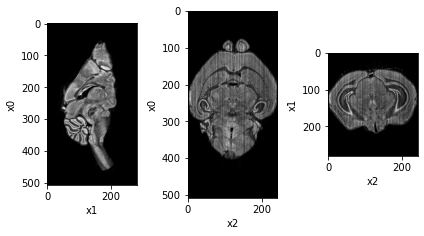

In [2]:
fixed_image = np.load('../data/ff/fixed_image.npy')
fixed_image = util.normalize_intensity(fixed_image)
util.imshow_midslice(fixed_image)

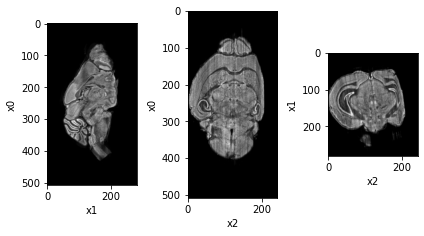

In [3]:
moving_image = np.load('../data/ff/moving_image_after_linear_reg.npy')
moving_image = util.normalize_intensity(moving_image)
util.imshow_midslice(moving_image)

## Prepare images for registration

In [4]:
dtype = torch.float32
device = torch.device('cpu')
scales = [1, 1, 1]

fixed_image = torch.tensor(fixed_image, dtype=dtype).to(device)
fixed_image = al.Image(fixed_image, fixed_image.shape, scales, [0, 0, 0])
moving_iamge = torch.tensor(moving_image, dtype=dtype).to(device)
moving_image = al.Image(moving_image, moving_image.shape, scales, [0, 0, 0])

## Prepare image pyramid

In [5]:
scales = [[4, 4, 4], [2, 2, 2]]

fixed_image_pyramid = al.create_image_pyramid(fixed_image, scales)
moving_image_pyramid = al.create_image_pyramid(moving_image, scales)
level_max = len(fixed_image_pyramid) - 1

## Run registration

In [6]:
lr = 5e-3
niter = [64, 16, 4]
regularisation_weight = [1, 2, 4]
sigma = [[4, 4, 4], [2, 2, 2], [1, 1, 1]]

In [7]:
import time

start = time.time()

for level, (mov_im, fix_im) in enumerate(zip(moving_image_pyramid, fixed_image_pyramid)):
    print('level', level)
    registration = al.PairwiseRegistration(verbose=True)

    transformation = al.transformation.pairwise.BsplineTransformation(
        mov_im.size,
        sigma=sigma[level],
        order=3,
        diffeomorphic=True
    )
    if level > 0:
        constant_flow = al.transformation.utils.upsample_displacement(
            constant_flow,
            mov_im.size,
            interpolation="linear"
        )
        transformation.set_constant_flow(constant_flow)
    registration.set_transformation(transformation)

    image_loss = al.loss.pairwise.MSE(fix_im, mov_im)
    registration.set_image_loss([image_loss])

    regulariser = al.regulariser.displacement.DiffusionRegulariser(mov_im.spacing)
    regulariser.set_weight(regularisation_weight[level])
    registration.set_regulariser_displacement([regulariser])

    optimizer = torch.optim.Adam(transformation.parameters())
    registration.set_optimizer(optimizer)
    registration.set_number_of_iterations(niter[level])

    registration.start()

    constant_flow = transformation.get_flow()

end = time.time()
print((end - start) / 60, 'min')

level 0
0 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


mse: 0.0029123178777956194 L2: 0.0 
1 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


mse: 0.0028982683561060148 L2: 4.111662121886184e-08 
2 mse: 0.0028451823656637947 L2: 1.5884891979567328e-07 
3 mse: 0.0027820040265081353 L2: 3.477821337583009e-07 
4 mse: 0.002718952144051319 L2: 6.025946959198336e-07 
5 mse: 0.002657210146250147 L2: 9.181054565488012e-07 
6 mse: 0.0025998044335441223 L2: 1.2883704130217666e-06 
7 mse: 0.002546338966138002 L2: 1.7075639107133611e-06 
8 mse: 0.0024972416163995376 L2: 2.1698037926398683e-06 
9 mse: 0.0024520231950967294 L2: 2.6693228392105084e-06 
10 mse: 0.0024095281363053205 L2: 3.2006830679165432e-06 
11 mse: 0.0023685839640278355 L2: 3.7589411476801615e-06 
12 mse: 0.0023295748198382247 L2: 4.339128281571902e-06 
13 mse: 0.002293161218182106 L2: 4.936776349495631e-06 
14 mse: 0.0022590371647826647 L2: 5.54769076188677e-06 
15 mse: 0.0022269601509457525 L2: 6.168201707623666e-06 
16 mse: 0.0021971072876244193 L2: 6.795002263970673e-06 
17 mse: 0.0021688668628194745 L2: 7.425173862429801e-06 
18 mse: 0.002142181573718136 L2: 8.05609

## Examine results

In [8]:
transformation

BsplineTransformation()

In [10]:
displacement = transformation.get_displacement()
warped_image = al.transformation.utils.warp_image(moving_image, displacement)
np.save('../data/ff/moving_image_after_diffeo_reg.npy', warped_image.image[0,0].numpy())

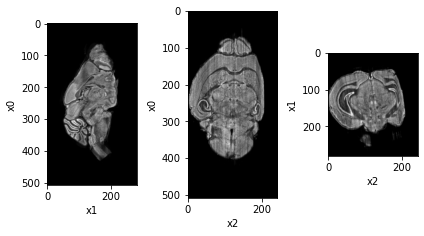

In [12]:
util.imshow_midslice(moving_image.image[0,0].numpy())

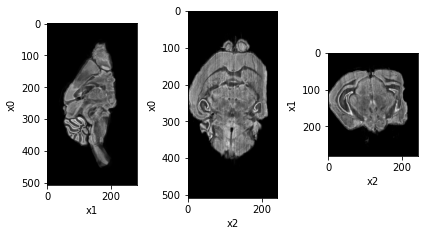

In [13]:
util.imshow_midslice(warped_image.image[0,0].numpy())

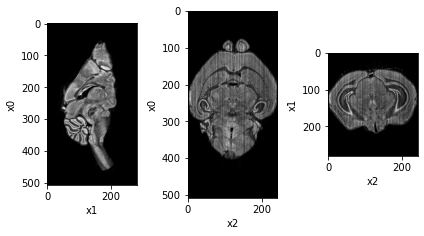

In [15]:
util.imshow_midslice(fixed_image.image[0,0].numpy())